# Characters Search Engine

To disambiguate the characters of Game of Thrones books, we need to have an authoritative source, curated and verified containing the final list of all characters. 

This list exist in the [wiki of ice and fire](https://awoiaf.westeros.org). So we want to build a search engine based on this wiki to send a character partial name and get the most corresponding list of potential characters, ranked. 

Many methods for ranking exists, from the search engine specific network analysis to building a custom function. Like all modern search engine, we will create our own ranking algorithm that will use many features as based data. 

To create our search engine we need to follow the following steps:
1. Download the HTML page for each character
2. Scrape the HTML page and extract relevant informations using beautiful soup
3. create the network of characters to create the page rank feature 
4. create the Bag of Words (BOW) that will be the basis for the search engine
5. optimize the search engine using our list of features 

## 1. Download the HTML page for each character

To download the characters we need to do it in two steps:
1. get a list of pages we shall scrape
2. scrape all the pages

### 1.1. Get the list of characters

Let's start by importing the required libraries to perform this task

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import numpy as np

To not be stopped by the awoif website, we hide ourselves very simply by changing the default python requests User-Agent

In [ ]:
url = 'https://awoiaf.westeros.org/index.php/List_of_characters'

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:121.0) Gecko/20100101 Firefox/121.0'}



We perfom the requests including our custom headers. headers can be omitted if you do not need to hide that you are a robot



In [ ]:
r = requests.get(url, headers=headers)

Finally we test the status of the server result and continue if we get a code 200

In [ ]:
if r.status_code == 200:
    print('request is a success')
else:
    print('request is a failure, status code is',r.status_code,' and error is', r.text)

The next step is to mount the DOM of the text. This is done using BeautifulSoup. 

Then we get to extract the list of link either using the find method to navigate the DOM tree or using the css selectors. we choose the latter.

A list in HTML is tagged as UL (Unordered List) and each item is tagged as LI (List Item)

In [ ]:
# get the soup 
soup = BeautifulSoup(r.text)

# find the li
links = soup.select('div.mw-parser-output li')[26:]

# find all relative links in each li and recreate an absolute path for all 
links_for_df = [f"https://awoiaf.westeros.org{link.find('a').attrs['href']}" for link in links]

# create a dataframe out of the list
records = {'characters_url':links_for_df}
dfscrape = pd.DataFrame.from_records(records)

# create a column to hold the scraped or not scraped status
dfscrape['scraped'] = False

# create a characters column to save the character page name for the future link analysis
dfscrape['characters'] = None

In [ ]:
dfscrape.head()

### 1.2 Get every characters webpage

for every link we found, it is time to get the page and store the resulting html

In [ ]:
def get_page(url):
    r = requests.get(url, headers=headers)
    if r.status_code != 200:
        print(f'request {url} is a failure, status code is {r.status_code} and error is {r.text}')
    time.sleep(0.1)
    return r.text

for i,row in dfscrape[~dfscrape.scraped].iterrows():
    html = get_page(row['characters_url'])
    dfscrape.iat[i,2] = html
    dfscrape.iat[i,1] = True
    break # REMOVE THIS LINE IF YOU WANT TO EXECUTE ALL 

finally after all is downloaded, we create files for each character, using the character name as a filename 

In [ ]:
for i,r in dfscrape.iterrows():
    filename = r['characters_url'].split('/')[-1]
    html = r['characters']
    with open(os.path.join('data','html_recent',filename),'w+') as fp:
        fp.write(html)
        fp.flush()


## 2. Scrape the HTML page and extract relevant informations using beautiful soup

Now that we have a directory containing all the html pages, we can read all files and convert it in a soup. 

From the soup we can extract all required informations

List of information to get from every page: 
1. title of the page
2. infobox name
3. aliases
4. page rank -> need to get Links to other pages
5. length of the text
6. books
7. mentionned or appear in each book
8. __the main text CLEANED__

### 2.1 HTML files into soup into dataframe

Read each html and make a soup out of it. 

In [551]:
import os

soups = []
pages = []

# walk through all the files in directory and for each, get the soup 
for dirpath, dirnames, filenames in os.walk('data/html_recent'):
    for filename in filenames:
        # we make sure the filename do not start with a dot as only hidden files do
        if not filename.startswith('.'): 
            pages.append(filename)  
            filepath = os.path.join(dirpath, filename)
            with open(filepath,'r', encoding='utf-8') as fp:
                html = fp.read()
                soup = BeautifulSoup(html)
                soups.append(soup)
df = pd.DataFrame.from_dict({'soup':soups, 'page':pages})

### 2.2 get features

based on the soup, we get all possible features

The most complicated one is the infobox that we transform into a dictionary object to anaylze it further later

we also define a clean text function to get only the useful words in text

In [553]:
def clean(text):
    clean_text = text.lower()

    #remove punctuation
    clean_text = re.sub(r"[^\w\s]","",clean_text)

    # Remove Unicode like unwanted characters
    clean_text = re.sub(r'[^\x00-\x7F]+', ' ',clean_text)

    # remove new line
    clean_text = re.sub(r'[\n]+', ' ',clean_text)

    # remove numbers
    clean_text = re.sub(r'[\d]+', ' ',clean_text)

    # normalize spaces
    clean_text = re.sub(r'[\s]+', ' ',clean_text)

    # remove stopwords whose frequency is too high
    with open('data/stopwords_en.txt','r') as fp:
        stopwords = [w.strip() for w in fp.readlines()]
    clean_text = [word for word in clean_text.split() if word not in stopwords]
    
    return ' '.join(clean_text)

In [554]:
pages = df.page.to_list()

def get_title_name(soup): 
    return soup.find("h1").get_text(' ',strip=True).strip()

def get_infobox_name(soup):
    try:
        return soup.find('div', id='mw-content-text').table.find('th',{'colspan':2}).get_text('|').strip().split('|')[-1]
    except AttributeError:
        return None

def get_aliases_name(infobox):
    return infobox.get('aliases',[])
    
def get_infobox(soup):
    try:
        ths = soup.find('div', id='mw-content-text').table.find_all('th',{"scope" : "row"} )
    except AttributeError:
        return {}

    infobox = {th.get_text().lower():re.sub(r"\[\d+\]", '', th.next_sibling.get_text('\n').strip()) for th in ths}
    
    if infobox.get('book') is not None:
        infobox['books'] = infobox['book']
        del infobox['book']
    
    if infobox.get('books') is not None:
        books = infobox.get('books')
        books = re.sub(r"((\n)\s\()|(\n\s\n\()", '-', books, 0, re.MULTILINE).replace(')','').split('\n')
        books = {b.split('-')[0]:b.split('-')[-1] for b in books}
        infobox['books'] = books
    
    if infobox.get('alias') is not None:
        infobox['aliases'] = infobox['alias']
        del infobox['alias']   
    
    if infobox.get('aliases') is not None:
        infobox['aliases'] = [al.lower() for al in infobox.get('aliases').split('\n') if len(al)>0]
    else:
        infobox['aliases'] = []

    if infobox.get('title') is not None:
        infobox['titles'] = infobox['title']
        del infobox['title']
    
    if infobox.get('titles') is not None:
        infobox['titles'] = [al for al in infobox.get('titles').split('\n') if len(al)>0]
    return infobox 

def get_text_length(soup):
    return len(' '.join([p.get_text() for p in soup.find_all("p")]))

def get_books(infobox):
    return infobox.get('books',{})

def get_text(soup):
    return clean(' '.join([p.get_text() for p in soup.find_all("p")]))

def get_links(soup):
    links = soup.find_all('a')
    links = [link for link in links if link.attrs.get('href') is not None]
    links = [link['href'].split('/')[-1] for link in links if link['href'].split('/')[-1] in pages and link['href'].startswith('/index')]
    return list(set(links))

print(get_title_name(df.sample(1).soup.values[0]))
print(get_infobox_name(df.sample(1).soup.values[0]))
print(get_infobox(df.loc[2197].soup))
print(get_aliases_name(get_infobox(df.sample(1).soup.values[0])))
print(get_text_length(df.sample(1).soup.values[0]))
print(get_books(get_infobox(df.loc[174].soup)))
print(get_text(df.sample(1).soup.values[0]))
print(get_links(df.sample(1).soup.values[0]))

Qoren Martell
 the Dread
{'aliases': ['the imp', 'halfman', 'boyman', 'giant of lannister', 'lord imp', "lord tywin's doom", "lord tywin's bane", 'yollo', 'hugor hill', 'hugor halfwit', 'no-nose', 'freak', 'redhands', 'ser imp', 'monkey demon', 'the bloody hand', 'the demonic dwarf'], 'titles': ['Acting ', 'Hand of the King', ' ', '(formerly)', 'Master of coin', ' ', '(formerly)', 'Lord of Casterly Rock', ' ', '(claimant)'], 'allegiances': 'House Lannister\nSecond Sons', 'predecessor': 'Petyr Baelish\n \n(master of coin)', 'successor': 'Gyles Rosby\n \n(master of coin)', 'culture': 'Westermen', 'born': 'In\xa0\n273\xa0AC\n\n\n,\xa0\nCasterly Rock\n', 'father': 'Lord \nTywin Lannister', 'mother': 'Lady \nJoanna Lannister', 'spouses': '1\nst\n: \nTysha\n \n(annulled)\n2\nnd\n: \nSansa Stark', 'lover': 'Shae', 'personal arms': 'A golden hand in a circle of golden lions on red\n\n(Gules, a hand or, environed by lions or)', 'books': {'The World of Ice & Fire': 'mentioned', 'A Game of Throne

### 2.3 Fill the features in the dataframe

Now that each function is using the soup OR the infobox dictionary, we can create the features inside the dataframe

Pay attention to the column used in the apply, most of the time it is the _soup_ but for __books__ and __aliases__ it is the _infobox_.


In [556]:
df['title'] = df.soup.apply(get_title_name)
df['infobox_name'] = df.soup.apply(get_infobox_name)
df['infobox'] = df.soup.apply(get_infobox)
df['aliases_names'] = df.infobox.apply(get_aliases_name)
df['text_length'] = df.soup.apply(get_text_length)
df['books'] = df.infobox.apply(get_books)
df['text'] = df.soup.apply(get_text)
df['links'] = df.soup.apply(get_links)
df['infobox_length'] = df.infobox.apply(lambda x:len(x))

### 2.4 Save everything except the soup into a pickle for later

In [557]:
df.columns

Index(['soup', 'page', 'title', 'infobox_name', 'infobox', 'aliases_names',
       'text_length', 'books', 'text', 'links', 'infobox_length'],
      dtype='object')

In [558]:
df[df.columns[1:]].to_pickle('awoif_heavy.pkl')

### 2.5 LOAD THE PICKLE

In [4]:
df = pd.read_pickle('awoif_heavy.pkl')

In [560]:
!pip install scipy


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


## 3 create a network to have network ranking features

The network has to be created using pages and links in the pages. 

### 3.1 create the network

In [6]:
import networkx as nx

In [7]:
G = nx.DiGraph()

for each page for each character we add all the links to other characters

In [8]:
for i,r in df.iterrows():
    page = r['page']
    for l in r['links']:
        G.add_edge(page, l)

In [9]:
print('–– Network Characteristics –– ')
print(f'\tNodes: {G.number_of_nodes()}')
print(f'\tEdges: {G.number_of_edges()}')

–– Network Characteristics –– 
	Nodes: 3468
	Edges: 53079


### 3.2 Calculate PageRank, Closeness Centrality and Betweeness Centrality

To calculate pageRank and centralities, refer to [networkx documentation](https://networkx.org/documentation/latest/ )

start with the pagerank and store it in a variable called __pr__

In [10]:
pr = nx.pagerank(G)

continue with the betweeness centrality and store it in a variable called __bc__

In [11]:
bc = nx.betweenness_centrality(G)

finish with the closeness centrality and store it in a variable called __cc__

In [12]:
cc = nx.closeness_centrality(G)

### 3.3 add each score as a new columns for all the pages in the dataframe

the columns shall be named respectively __pagerank__, __betweeness__, __closeness__

the pr, bc and cc are all dictionaries keyed with page name. 

The page name is in the column page of the dataframe sor make good use of:
 - apply function for dataframes
 - get function for dictionaries
 - lambda function from python 

In [13]:
df['pagerank'] = df.page.apply(lambda x: pr.get(x,0))

In [14]:
df['betweeness'] = df.page.apply(lambda x: pr.get(x,0))

In [15]:
df['closeness'] = df.page.apply(lambda x: cc.get(x,0))

### 3.4 check the influence of each network indicator

To measure the influence of each indicator, or the indicator bringing more information, we can start by checking if these indicators are correlated

Find the correlation between these 3 columns, what do you observe? 

_Hint: pandas as a correlation function_

In [16]:
df[['pagerank', 'betweeness', 'closeness']].corr()

,pagerank,betweeness,closeness
pagerank,1.000000,1.000000,0.436078
betweeness,1.000000,1.000000,0.436078
closeness,0.436078,0.436078,1.000000


Our space has 3 dimensions right now. We can use Principal component Analysis PCA to evaluate the information each variable bring.

Apply PCA method from sklearn to our 3 columns. see pdf join and [sklearn PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

What can you conclude? Do we need the 3 variables? Which one explain the variance the most?

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df[['pagerank', 'betweeness', 'closeness']].to_numpy())

PCA(n_components=2)

Print the explained variance ratio

In [16]:
pca.explained_variance_ratio_

array([9.99974784e-01, 2.52158731e-05])

print the components

In [17]:
pca.components_

array([[ 0.0017207 ,  0.0017207 ,  0.99999704],
       [ 0.70710469,  0.70710469, -0.00243344]])

To finish, let's plot the histogram of the network scores 

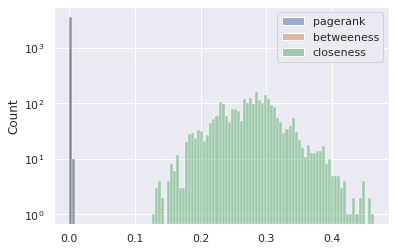

In [18]:
import seaborn as sns

sns.set()
ax = sns.histplot(df[['pagerank', 'betweeness', 'closeness']], bins=100)
ax.set_yscale('log')

## 3.5 create a custom distance 

Let's compare the ranking performance of our network indicator together

First create a combination of the three score, using an euclidean and a minkowski distance.

Why is it is done from 0,0,0 to something ? 

Why is axis = 1 ? 

In [19]:
from scipy.spatial import distance
df['euclidean'] = df[['pagerank', 'betweeness', 'closeness']].apply(lambda x : distance.euclidean([0,0,0],x.to_numpy()), axis=1)
df['minkowski'] = df[['pagerank', 'betweeness', 'closeness']].apply(lambda x : distance.minkowski([0,0,0],x.to_numpy()), axis=1)

now we create a custom function that takes a list of pages, and return the top 10 according to the chosen ranking algorithm

In [20]:
def rank_these_pages(pages_list, method='euclidean'):
    results = df.loc[pages_list,:].sort_values(by=[method],ascending=False)[:10]
    return list(results.page)

at last we create a dataframe to easily see the difference between the ranking methods. 

What can you conclude? 

In [21]:
ranking_data = {'pagerank':rank_these_pages(df.index, method='pagerank'), 
                'betweeness':rank_these_pages(df.index, method='betweeness'),
                'closeness':rank_these_pages(df.index, method='closeness'),
                'euclidean':rank_these_pages(df.index, method='euclidean'),
                'minkowski':rank_these_pages(df.index, method='minkowski')}
df_ranking = pd.DataFrame.from_dict(ranking_data)
df_ranking

,pagerank,betweeness,closeness,euclidean,minkowski
0,Tyrion_Lannister,Tyrion_Lannister,Stannis_Baratheon,Stannis_Baratheon,Stannis_Baratheon
1,Stannis_Baratheon,Stannis_Baratheon,Tyrion_Lannister,Tyrion_Lannister,Tyrion_Lannister
2,Daenerys_Targaryen,Daenerys_Targaryen,Robb_Stark,Robb_Stark,Robb_Stark
3,Jaime_Lannister,Jaime_Lannister,Joffrey_Baratheon,Joffrey_Baratheon,Joffrey_Baratheon
4,Arya_Stark,Arya_Stark,Tommen_Baratheon,Tommen_Baratheon,Tommen_Baratheon
5,Jon_Snow,Jon_Snow,Daenerys_Targaryen,Daenerys_Targaryen,Daenerys_Targaryen
6,Cersei_Lannister,Cersei_Lannister,Eddard_Stark,Eddard_Stark,Eddard_Stark
7,Eddard_Stark,Eddard_Stark,Cersei_Lannister,Cersei_Lannister,Cersei_Lannister
8,Tywin_Lannister,Tywin_Lannister,Jaime_Lannister,Jaime_Lannister,Jaime_Lannister
9,Robb_Stark,Robb_Stark,Tywin_Lannister,Tywin_Lannister,Tywin_Lannister


## 4 documents matching a query

A search engine dissociate the documents corresponding to a query from the ranking of these documents. 

Henceforth, before we can rank documents according to a query, wee need to be able to retrieve all document that correspond to a query.

To do this we have many solutions:
1. dumb solution is to look for the work in the documents using a simple test of the word or group of words in the text.
2. the __easiest__ is to compare the words of the query with the text and return documents containing the text. Popular methods to do this are:
    - Jaccard Similarity
    - w-shingling
    - Pearson Similarity
    - Levenshtein distance
    - Normalized Google Distance 
3. more advanced method include vectorizations. The documents are summarized into vectors and the similarity is not with the words but with vectors representing the words:
    - Count vectorizer
    - TFIDF vectorizer
    - Word2vec
    - Embeddings (BERT)
5. Lastly, and this is how the search engine would work, you use a clever mix of prior knowledge and custom features together with the text and the vectorization, and of course the ranking features. 

For these examples we will use the word __'ned'__ and __'the queen's hand'__ 

### 4.1 Dumb Solution find 

we write a function that look if the query word are both in the text, aliases and names, and send back index of documents that match.

In [22]:
df['bow'] = df['text'].str.split()

In [23]:
query1 = 'ned'
query2 = "queen hand"

def dumb_find(query):
    masks = []
    for q in query.split():
        print(q)
        mask = [q in ws for ws in df['bow']]
        masks.append(mask)
        print(sum(mask), len(mask))
    
    mask = [all(tup) for tup in zip(*masks)]
    mask_alias = [query in ws for ws in df['aliases_names'] if ws is not None]
    mask_title = df.title.str.contains(f"\b{query}\b", case=False, regex=True)
    mask_infobox_name = df.infobox_name.str.contains(f"\b{query}\b", case=False, regex=True)
    final_mask = [any(tup) for tup in zip(mask, mask_alias, mask_title, mask_infobox_name)]
    return df[final_mask]
    
dumb_find(query1).page.head()

ned
52 3669


174     Eddard_Stark
282    Hallis_Mollen
352     Lyanna_Stark
355            Quent
402      Edric_Dayne
Name: page, dtype: object

apply the ranking method to the previous result to see the most likely prediction. 

display the top 10 result. Which is the predicted character for Ned? and for Queen Hand ? 

In [24]:
rank_these_pages(dumb_find(query1).index)

ned
52 3669


['Stannis_Baratheon',
 'Joffrey_Baratheon',
 'Eddard_Stark',
 'Cersei_Lannister',
 'Jaime_Lannister',
 'Renly_Baratheon',
 'Jon_Snow',
 'Robert_I_Baratheon',
 'Catelyn_Stark',
 'Bran_Stark']

In [25]:
rank_these_pages(dumb_find(query2).index)

queen
695 3669
hand
594 3669


['Stannis_Baratheon',
 'Tyrion_Lannister',
 'Robb_Stark',
 'Joffrey_Baratheon',
 'Tommen_Baratheon',
 'Daenerys_Targaryen',
 'Eddard_Stark',
 'Cersei_Lannister',
 'Jaime_Lannister',
 'Tywin_Lannister']

### 4.2 JACCARD Solution find 

the easy solution to compare the query and the text suppose different strategies. 

For jaccard, we want to build a score based on the difference between length of intersection of query set and text word set and the length of the union of it

In [26]:
def jaccard(query):
    query_set = set(query.split())
    jaccard = df.bow.apply(lambda x: len(set(x).intersection(query_set)) / len(set(x).union(query_set)))
    return df[jaccard > 0]

rank_these_pages(jaccard(query2).index)
    

['Stannis_Baratheon',
 'Tyrion_Lannister',
 'Robb_Stark',
 'Joffrey_Baratheon',
 'Tommen_Baratheon',
 'Daenerys_Targaryen',
 'Eddard_Stark',
 'Cersei_Lannister',
 'Jaime_Lannister',
 'Tywin_Lannister']

jaccard can also be used to rank but it is not the best at ranking since it is solely based on the size of sets. 

Another similar technique is w-shingling. w-shingling uses the exact same logic of intersection / union — but with ‘shingles’ also called 2-grams. A 2-gram is sequence of two word instead of a single word. Google has revealed a popular version of this using n-grams that you can try in [Google ngrams](https://books.google.com/ngrams/)

We will skip this technique as it is only a matter of programming to use another technique called levenstein distance

The [levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) measure the similarity between two string by measuring how many change are necessary to go from to the other. It is used to correct entries in search queries when user makes a typo. Lets try it with suggesting the most likely alternative to __'nud'__, a mispelling of __'ned'__. 

[Documentation Levenshtein](https://rapidfuzz.github.io/Levenshtein/levenshtein.html#distance)

In [27]:
import Levenshtein
import string

write a function most_likely_word that tries every single letter in ascii with nud, calculate the levenstein distance with each word in the bow, retrieve the minimum and sum the result for each text. 

The result need to be put in a dictionary containing key=word and value=sum of the min distance 

What is the most likely word similar to nud that would yield good result with our dataframe ? 

In [28]:
word = 'nud'

def most_likely_word(word):
    result = {}
    for i in range(len(word)):
        for l in string.ascii_lowercase:
            if word[i] != l:
                new_word = list(word)
                new_word[i] = l
                new_word = ''.join(new_word)
                leven = df.bow.apply(lambda x: min([Levenshtein.distance(w,new_word) for w in x]))
                result[new_word] = sum(leven)
    return result
result = most_likely_word(word)
result.get('iud')

9360

In [29]:
sorted(result.items(), key=lambda x: x[1])[:5]

[('ned', 7542), ('nod', 8268), ('nad', 8296), ('lud', 8325), ('oud', 8576)]

In [30]:
print(f'you probably mean "{sorted(result.items(), key=lambda x: x[1])[0][0]}" instead of "{word}"')

you probably mean "ned" instead of "nud"


### 4.3 the vectorized Solution

For vector-based search, we typically find one of several vector building methods:
- TF-IDF
- BM25
- word2vec/doc2vec
- BERT

In tandem with some implementation of approximate nearest neighbors (ANN), these vector-based methods are the MVPs in the world of similarity search.

We will start with a basic approach the count vectorizer. The count vectorizer is quite naive and convert a collection of text documents to a matrix of token counts.

This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#### 4.3.1 Count vectorizer

We start with the count vectorizer. The count vectorizer count how many time each token or each word of the vocabulary appears in the text. 

There will be as many columns as there is unique word in the text.

Therefore each document (each row if you will) will be a vector with length-of-the-vocabulary dimensions (big). 

In [32]:
# initialize the vectorizer
vectorizer = CountVectorizer()

# initialize the vocabulary and the count and fit it with the text from the df
doc_term_matrix = vectorizer.fit_transform(df.text)

print('the vocabulary is ', vectorizer.get_feature_names_out())

the vocabulary is  ['aahooooooo' 'abandon' 'abandoned' ... 'zorse' 'zorseface' 'zorseriders']


In [33]:
print('the length of the vocabulary is', doc_term_matrix.shape[1])

the length of the vocabulary is 22389


we transform the doc_term_matrix into a dataframe so you can take a look at it

In [34]:
df_vectorizer = pd.DataFrame(
   doc_term_matrix.todense(),
   columns=vectorizer.get_feature_names_out(),
   index=df.page
)

In [35]:
df_vectorizer.head()

,aahooooooo,abandon,abandoned,abandoning,abandonment,abandons,abate,abated,abdicate,abdicated,...,zherzyn,zhoe,zia,zo,zollo,zone,zoqora,zorse,zorseface,zorseriders
page,,,,,,,,,,,,,,,,,,,,,
Garth_the_Gardener,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nymor_Martell,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lyman_Lannister,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tommen_Costayne_(knight),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ernest_Dabell,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now to query the dataset, we simply need to _transform our query in a similar vector object_ with the same vocabulary, hence the same columns, using the __transform__ function of the __vectorizer__ model and not the fit_transform!

We obtain a vector that we will compare to other vectors or documents

In [36]:
query1

'ned'

In [37]:
query_vec = vectorizer.transform([query1])

In [38]:
query_vec

<1x22389 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

Once we have the query vector, we can calculate the distance between this vector and each document vector to find the most likely document in the list, the one where the vector are more similar.

For that we use the [__cosine similarity__](https://en.wikipedia.org/wiki/Cosine_similarity). Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space based on the cosine of the angle between them, resulting in a value between -1 and 1. The value -1 means that the vectors are opposite, 0 represents orthogonal vectors, and value 1 signifies similar vectors.

We use the [sklearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html#examples-using-sklearn-metrics-pairwise-cosine-similarity) and reshape it to be just one dimensional with all the similarity scores. 

In [39]:
cosim = cosine_similarity(doc_term_matrix, query_vec).reshape(3669,)

Now we can retrieve the top 10 vector with the highest scores. We get an index list so it can be used directly in the ranking function

In [40]:
top10_similar_to_query = np.argsort(cosim)[-10:]
rank_these_pages(top10_similar_to_query)

['Eddard_Stark',
 'Jory_Cassel',
 'Godric_Borrell',
 'Edric_Dayne',
 'Willam_Dustin',
 'Ned_Bean',
 'Humfrey_Clifton',
 'Ned_Woods',
 'Porther',
 'Ned_(ferryman)']

In [41]:
df.loc[top10_similar_to_query]

,page,title,infobox_name,infobox,aliases_names,text_length,books,text,links,infobox_length,pagerank,betweeness,closeness,euclidean,minkowski,bow
2909,Humfrey_Clifton,Humfrey Clifton,Humfrey Clifton,{'allegiances': 'House Clifton House Baratheon...,[],615,{'A Dance with Dragons': 'appears'},humfrey clifton knight house clifton sworn swo...,"[Stannis_Baratheon, Ned_Woods, Gareth_Clifton]",5,0.000059,0.000059,0.248314,0.248314,0.248314,"[humfrey, clifton, knight, house, clifton, swo..."
1146,Jory_Cassel,Jory Cassel,Jory Cassel,"{'allegiances': 'House Cassel House Stark', 'c...",[],5186,"{'A Game of Thrones': 'appears', 'A Clash of K...",jory cassel house cassel captain household gua...,"[Tyrion_Lannister, Beth_Cassel, Gared, Rodrik_...",10,0.000373,0.000373,0.330794,0.330794,0.330794,"[jory, cassel, house, cassel, captain, househo..."
3636,Godric_Borrell,Godric Borrell,Godric Borrell,"{'titles': ['Lord of Sweetsister', 'Shield of ...",[],3355,"{'A Feast for Crows': 'appendix', 'A Dance wit...",godric borrell lord sweetsister shield sistert...,"[Wyman_Manderly, Tywin_Lannister, Lord_Borrell...",8,0.000228,0.000228,0.321301,0.321301,0.321301,"[godric, borrell, lord, sweetsister, shield, s..."
2922,Porther,Porther,Porther,"{'allegiance': 'House Stark', 'culture': 'Nort...",[],348,"{'A Game of Thrones': 'appears', 'A Clash of K...",porther household guard lord eddard stark wint...,"[Bran_Stark, Eddard_Stark]",5,0.000044,0.000044,0.000000,0.000062,0.000062,"[porther, household, guard, lord, eddard, star..."
1115,Willam_Dustin,Willam Dustin,Willam Dustin,"{'allegiance': 'House Dustin', 'successor': 'B...",[],1983,"{'A Game of Thrones': 'mentioned', 'A Feast fo...",willam dustin lord barrowton head house dustin...,"[Barbrey_Dustin, Theon_Greyjoy, Catelyn_Stark,...",8,0.000163,0.000163,0.304846,0.304846,0.304846,"[willam, dustin, lord, barrowton, head, house,..."
174,Eddard_Stark,Eddard Stark,Eddard Stark,"{'aliases': ['ned', 'the quiet wolf', 'the ned...","[ned, the quiet wolf, the ned]",25094,"{'The World of Ice & Fire': 'mentioned', 'A Ga...",eddard stark called ned head house stark lord ...,"[Elia_Martell, Brandon_Stark, Kevan_Lannister,...",16,0.005050,0.005050,0.447051,0.447108,0.447108,"[eddard, stark, called, ned, head, house, star..."
402,Edric_Dayne,Edric Dayne,Edric Dayne,{'allegiances': 'House Dayne brotherhood witho...,[ned],4570,"{'A Game of Thrones': 'appendix', 'A Clash of ...",edric dayne ned lord starfall head house dayne...,"[Sandor_Clegane, Ashara_Dayne, Loras_Tyrell, A...",6,0.000224,0.000224,0.316675,0.316675,0.316675,"[edric, dayne, ned, lord, starfall, head, hous..."
2388,Ned_(ferryman),Ned (ferryman),Ned,"{'culture': 'Rivermen', 'books': {'The Mystery...",[],366,{'The Mystery Knight': 'appears'},ned ferryman inn lakeshore whitewalls reign ki...,"[Lord_Shawney, Lord_Costayne_(Aerys_I), Aerys_...",3,0.000044,0.000044,0.000000,0.000062,0.000062,"[ned, ferryman, inn, lakeshore, whitewalls, re..."
3290,Ned_Bean,Ned Bean,Ned Bean,"{'allegiance': 'House Targaryen', 'books': {'F...",[blackbean],1143,"{'Fire & Blood': 'mentioned', 'The Rise of the...",ned bean called blackbean notorious sellsail s...,"[Gedmund_Peake, Unwin_Peake, Aegon_III_Targary...",4,0.000080,0.000080,0.250967,0.250967,0.250967,"[ned, bean, called, blackbean, notorious, sell..."
2482,Ned_Woods,Ned Woods,Ned Woods,"{'allegiance': 'House Woods', 'culture': 'Nort...",[noseless ned],328,{'A Dance with Dragons': 'appears'},ned woods noseless ned house woods wolfswood s...,"[Stannis_Baratheon, Sybelle_Glover]",4,0.000061,0.000061,0.196714,0.196714,0.196714,"[ned, woods, noseless, ned, house, woods, wolf..."


#### 4.3.2 TFIDF vectorizer

TF-IDF consists of two parts, Term Frequency (TF) and Inverse Document Frequency (IDF).

The TF component counts the number of times a term appears within a document and divides this by the total number of terms in that same document.

The Term Frequency is a good measure, but doesn’t allow us to differentiate between common and uncommon words. If we were to search for the word ‘the’ — using TF alone we’d assign this sentence the same relevance as had we searched ‘bananas’.

That’s fine until we begin comparing documents, or searching with longer queries. We don’t want words like ‘the’,_ ‘is’_, or _‘it’_ to be ranked as highly as _‘bananas’_ or _‘street’_.

Ideally, we want matches between rarer words to score higher. To do this, we can multiply TF by the second term — IDF. The Inverse Document Frequency measures how common a word is across all of our documents.

In [42]:
# initialize the vectorizer
vectorizer = TfidfVectorizer()

# initialize the vocabulary and the count and fit it with the text from the df
doc_term_matrix = vectorizer.fit_transform(df.text)

print('the vocabulary is ', vectorizer.get_feature_names_out())

print('the length of the vocabulary is', doc_term_matrix.shape[1])

df_vectorizer = pd.DataFrame(
   doc_term_matrix.todense(),
   columns=vectorizer.get_feature_names_out(),
   index=df.page
)

df_vectorizer.head()

the vocabulary is  ['aahooooooo' 'abandon' 'abandoned' ... 'zorse' 'zorseface' 'zorseriders']
the length of the vocabulary is 22389


,aahooooooo,abandon,abandoned,abandoning,abandonment,abandons,abate,abated,abdicate,abdicated,...,zherzyn,zhoe,zia,zo,zollo,zone,zoqora,zorse,zorseface,zorseriders
page,,,,,,,,,,,,,,,,,,,,,
Garth_the_Gardener,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nymor_Martell,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lyman_Lannister,0.0,0.0,0.024355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tommen_Costayne_(knight),0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ernest_Dabell,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
query = 'Tyrion lannister'
qvectors = []
for q in query.split(): 
    qvector = vectorizer.transform([q])
    qvectors.append(qvector.todense())

qvector_mean = np.mean(qvectors, axis=0)
cosim = cosine_similarity(doc_term_matrix, qvector_mean).reshape(3669,)
top10_similar_to_query = np.argsort(cosim)[-10:]
rank_these_pages(top10_similar_to_query)

['Tyrion_Lannister',
 'Shae',
 'Tysha',
 'Penny',
 'Symon_Silver_Tongue',
 'Jyck',
 'Tyrion_III_Lannister',
 'Tyrion_II_Lannister',
 'Cerenna_Lannister',
 'Myrielle_Lannister']

In [44]:
cosim

array([0.        , 0.        , 0.02797729, ..., 0.        , 0.        ,
       0.        ])

#### 4.3.3 Word2vec, Doc2vec

word2vec is not a singular algorithm, rather, it is a family of model architectures and optimizations that can be used to learn word embeddings from large datasets. Embeddings learned through word2vec have proven to be successful on a variety of downstream natural language processing tasks:
- ref [gensim word2vec](https://radimrehurek.com/gensim/models/word2vec.html)
- ref [tensoflow word2vec](https://www.tensorflow.org/text/tutorials/word2vec)


In [45]:
import gensim
from gensim.models import Word2Vec

In [46]:
# Create CBOW model
model1 = gensim.models.Word2Vec(df.bow, min_count = 1, 
                              vector_size = 100, window = 5)

In [47]:
# Print results
print("Cosine similarity between 'queen' and 'hand' - CBOW : ",
      model1.wv.similarity('queen', 'hand'))

Cosine similarity between 'queen' and 'hand' - CBOW :  0.57926357


In [48]:
# Create Skip Gram model
model2 = gensim.models.Word2Vec(df.bow, min_count = 1, vector_size = 100,
                                             window = 5, sg = 1)

In [49]:
# Print results
print("Cosine similarity between 'queen' and 'hand' - CBOW : ",
    model2.wv.similarity('queen', 'hand'))

Cosine similarity between 'queen' and 'hand' - CBOW :  0.21280481


In [50]:
model2.wv.get_vector('ned')

array([ 2.77107298e-01,  1.99746504e-01, -4.22578044e-02, -2.81017095e-01,
        3.00629526e-01, -3.83131713e-01,  2.63958097e-01,  4.58949834e-01,
       -4.23339568e-02, -4.61202979e-01,  9.16755106e-03, -5.58270991e-01,
       -1.22624755e-01, -2.09035009e-01,  4.43659484e-01,  3.75547782e-02,
       -5.07404171e-02,  1.74354643e-01,  1.10094018e-01, -4.53469813e-01,
        4.14801925e-01, -3.35903943e-01, -4.58152771e-01,  1.40801342e-02,
       -4.21119750e-01,  3.79248828e-01, -5.46472669e-01, -3.16807926e-01,
       -1.56888086e-02, -5.84754981e-02,  1.63402408e-01,  6.11822456e-02,
       -1.37414597e-03, -4.57556337e-01,  3.33591431e-01, -2.01587498e-01,
        4.04244661e-01, -2.52163976e-01, -3.63813564e-02, -3.67035091e-01,
       -2.84338057e-01, -3.17353815e-01, -3.23182434e-01, -3.64508450e-01,
       -3.98589224e-01, -3.21976990e-01, -4.72514063e-01,  6.58583418e-02,
        1.14823021e-01,  2.98412174e-01, -1.08382897e-02, -4.47700918e-01,
        6.65694103e-02,  

In [51]:
df['word2vec'] = df.bow.apply(model2.wv.get_mean_vector)

In [52]:
q1v = model2.wv.get_mean_vector("dragon".split()) 

cosim = df.word2vec.apply(lambda x: cosine_similarity([x], [q1v]))

top10_similar_to_query = np.argsort(cosim)[-10:]
rank_these_pages(top10_similar_to_query)

['Aemond_Targaryen',
 'Addam_Velaryon',
 'Nettles',
 'Loreth_Lansdale',
 'Robin_(Flea_Bottom)',
 'Dhako',
 'Elinda_Massey',
 'Byron_Swann',
 'Bean',
 'Jaenara_Belaerys']

In [53]:
q1v = model2.wv.get_mean_vector("kingslayer".split()) 

cosim = df.word2vec.apply(lambda x: cosine_similarity([x], [q1v]))

top10_similar_to_query = np.argsort(cosim)[-10:]
rank_these_pages(top10_similar_to_query)

['Jaime_Lannister',
 'Ilyn_Payne',
 'Boros_Blount',
 'Tion_Frey',
 'Lewys_Piper',
 'Josmyn_Peckledon',
 'Emmon_Cuy',
 'Lyle_Crakehall',
 'Enger',
 'Hoke']

With the Word2Vec model, we can calculate the vectors for each word in a document. But what if we want to calculate a vector for the entire document? We could average the vectors for each word in the document - while this is quick and crude, it can often be useful. However, there is a better way…

Introducing: Paragraph Vector

## 5 Assemble everything

In [54]:
def get_corpus(query, book):
    q = query.lower().split()
    
    # limit the corpus only to books where the search is supposed to occur
    mask_book = df.books.apply(lambda x: np.any([book.lower() == k.lower() for k in x.keys()]))
    corpus = df.loc[mask_book]
    i_corpus = set(corpus.index)
    
    # query in main title
    mask_title = corpus.title.apply(lambda x: set(q).issubset(set(x.lower().split())))
    i_main_title = set(corpus[mask_title].index)
    
    # query in infobox name
    mask_infobox_name = corpus.infobox_name.apply(lambda x: set(q).issubset(set(x.lower().split())))
    i_infobox_name = set(corpus[mask_infobox_name].index)
    
    # query in aliases 
    mask_aliases = corpus.aliases_names.apply(lambda x: np.any([set(q).issubset(set(a.lower().split())) for a in x]))
    i_aliases = set(corpus[mask_aliases].index)
    i_aliases
    
    # top 20 in text with tdf-idf vectorizer
    qvectors = []
    for q in query.lower().split(): 
        qvector = vectorizer.transform([q])
        qvectors.append(qvector.todense())
    qvector_mean = np.mean(qvectors, axis=0)
    
    cosim = cosine_similarity(doc_term_matrix, qvector_mean).reshape(3669,)
    top20 = np.argsort(cosim)[-20:]
    i_top20 = set(top20).intersection(i_corpus)
    i_top20
    
    # assemble all
    return (i_main_title,
            i_infobox_name,
            i_aliases,
            i_main_title.union(i_infobox_name).union(i_aliases).union(i_top20))

get_corpus('blackwood','a dance with dragons')

({374, 498, 576, 696, 1227, 1547, 1688, 2246, 3560, 3664},
 {374, 498, 576, 696, 1227, 1547, 1688, 2246, 3560, 3664},
 set(),
 {374, 498, 576, 696, 1227, 1547, 1688, 2246, 3560, 3664})

In [103]:


def predict(corpus, book):
    i_main_title, i_infobox_name, i_aliases, full_i  = corpus
    
    role_score = {'None':0, 'appendix':0.25, 'mentioned':0.5, 'appears':0.75, 'pov':1}

    corpus_scores = []
    for i in full_i:
        role = {k.lower():v.lower() for k,v  in df.at[i,'books'].items()}.get(book,'None')
        network_score = df.at[i,'euclidean']
        
        score = {
            'index': i,
            'character': df.at[i,'title'],
            'title_name': 1 if i in i_main_title else 0,
            'infobox_name': 1 if i in i_infobox_name else 0,
            'aliases': 1 if i in i_aliases else 0,
            'role': role_score.get(role),
            'network_score': network_score
        }
        corpus_scores.append(score)
    # print(corpus_scores)
    if corpus_scores:
        score_df = pd.DataFrame.from_records(corpus_scores,index='index')
        score_df['rank'] = np.max([score_df.title_name, score_df.infobox_name], axis=0) * 0.1 + \
                        score_df.aliases * 0.1 + \
                        score_df.role * 0.1 + \
                        score_df.network_score * 0.7
        return score_df.sort_values(by='rank',ascending=False)
    else:
        return pd.DataFrame([])

predict(get_corpus('Lady Stark','a dance with dragons'),'a dance with dragons')

,character,title_name,infobox_name,aliases,role,network_score,rank
index,,,,,,,
488,Rodrik Stark (son of Beron),0,0,0,0.5,0.341693,0.289185


To use this on our text, we need 
DF
vectorizer model
doc_term_matrix


In [56]:
ner_df = pd.read_pickle('GOT-NER.pickle')

In [57]:
ner_df

,book,title,text,persons
0,1,Prologue,"""We should start back,"" Gared urged as the woo...","[Waymar Royce, Gared, Wall, Royce, Ser Waymar ..."
1,1,Bran,"The morning had dawned clear and cold, with a ...","[B, Jon, Old Nan, Mance Rayder, Bran, Robb]"
2,1,Catelyn,Catelyn had never liked this godswood.\n\tShe ...,"[At, Catelyn, Ned]"
3,1,Daenerys,Her brother held the gown up for her inspectio...,"[Illyrio, Dany, Her, Drogo, Viserys, Khal, Be]"
4,1,Eddard,The visitors poured through the castle gates i...,"[Jaime Lannister, Tyrion Lannister, Ser, Rober..."
...,...,...,...,...
340,5,Jon,"Let them die,"" said Queen Selyse.\n\tIt was th...","[Ser Narbert, Devan Seaworth, Ser Brus, Ser Do..."
341,5,Trueborn Lord Of Winterfell.,"""Snow?"" said Tormund Giantsbane. ""You look lik...","[Melisandre, Mance, Jon Snow, Jon, Tormund Gia..."
342,5,The Queen'S Hand,The Dornish prince was three days dying.\n\tHe...,"[Ser Barristan Selmy, Quentyn Martell, Ser, Rh..."
343,5,Daenerys,The hill was a stony island in a sea of green....,"[She, Dany, Daenerys, Drogon, Bay, Valyria]"


In [66]:
books_dic = {1: 'A Game of Thrones', 2: 'A Clash of Kings', 3: 'A Storm of Swords', 4: 'A Feast for Crows', 5: 'A Dance with Dragons'}

ner_df['books_name'] = ner_df.book.apply(lambda x: books_dic[x])
ner_df

,book,title,text,persons,books_name
0,1,Prologue,"""We should start back,"" Gared urged as the woo...","[Waymar Royce, Gared, Wall, Royce, Ser Waymar ...",A Game of Thrones
1,1,Bran,"The morning had dawned clear and cold, with a ...","[B, Jon, Old Nan, Mance Rayder, Bran, Robb]",A Game of Thrones
2,1,Catelyn,Catelyn had never liked this godswood.\n\tShe ...,"[At, Catelyn, Ned]",A Game of Thrones
3,1,Daenerys,Her brother held the gown up for her inspectio...,"[Illyrio, Dany, Her, Drogo, Viserys, Khal, Be]",A Game of Thrones
4,1,Eddard,The visitors poured through the castle gates i...,"[Jaime Lannister, Tyrion Lannister, Ser, Rober...",A Game of Thrones
...,...,...,...,...,...
340,5,Jon,"Let them die,"" said Queen Selyse.\n\tIt was th...","[Ser Narbert, Devan Seaworth, Ser Brus, Ser Do...",A Dance with Dragons
341,5,Trueborn Lord Of Winterfell.,"""Snow?"" said Tormund Giantsbane. ""You look lik...","[Melisandre, Mance, Jon Snow, Jon, Tormund Gia...",A Dance with Dragons
342,5,The Queen'S Hand,The Dornish prince was three days dying.\n\tHe...,"[Ser Barristan Selmy, Quentyn Martell, Ser, Rh...",A Dance with Dragons
343,5,Daenerys,The hill was a stony island in a sea of green....,"[She, Dany, Daenerys, Drogon, Bay, Valyria]",A Dance with Dragons


In [76]:
i1 = ner_df.iloc[2].persons[0]
i1

'At'

In [77]:
i2 = ner_df.iloc[2].books_name
i2

'A Game of Thrones'

In [78]:
predict(get_corpus(i1,i2),i2)

,character,title_name,infobox_name,aliases,role,network_score,rank
index,,,,,,,
2627,Stannis Baratheon,0,0,1,0,0.464123,0.424886
1214,Othor,0,0,0,0,0.326786,0.228750
1226,Desmera Redwyne,0,0,0,0,0.316804,0.221763
1211,Masha Heddle,0,0,0,0,0.309655,0.216758
1224,Ulf,0,0,0,0,0.235689,0.164982


In [75]:
predict(get_corpus(i1,i2),i2).iloc[0].character

'Waymar Royce'

In [105]:
from tqdm import tqdm

characters_link = []
characters_present = []

for _,row in tqdm(ner_df.iterrows()):
    book = row.books_name
    persons = row.persons
    characters_real_name = []
    for person in persons:
        search_result = predict(get_corpus(person,book),book)
        if search_result.size:
            search_result = search_result.iloc[0].character
            characters_real_name.append(search_result)

    characters_real_name = set(characters_real_name)
    
    for charac_link in characters_real_name:
        
        if charac_link in characters_present:            
            for character in characters_link:
                if character['name'] == charac_link:
                    for charac_tmp in characters_real_name:
                        if (charac_link != charac_tmp) and (charac_tmp not in character['links']):
                            character['links'].append(charac_tmp)
                            
                    break
                            
        else:
            characters_present.append(charac_link)
            list = []
            for charac_tmp in characters_real_name:
                if charac_link != charac_tmp:
                    list.append(charac_tmp)
            characters_link.append({'name': charac_link, 'links': list})

345it [01:46,  3.23it/s]


In [107]:
final_df = pd.DataFrame(characters_link)

In [108]:
import networkx as nx

F = nx.DiGraph()
for index, row in final_df.iterrows():
    page = row['name']
    for l in row['links']:
        F.add_edge(page,l) # create the link between the node and its 'childrens'

In [110]:
F.number_of_edges()

14672

In [111]:
F.number_of_nodes()

570

In [113]:
full_list=[]
for l in ner_df.persons.values:
    full_list.extend(l)


In [116]:
len(set(full_list))

1158

In [117]:
nx.write_gexf(F, 'final_exam.gexf')